# Portfolio Analysis using `pyfolio`

There are many ways to evaluate and analyze an algorithm. While we already provide you with some of these measures like a cumulative returns plot in the Quantopian backtester, you may want to dive deeper into what your algorithm is doing. For example, you might want to look at how your portfolio allocation changes over time, or what your exposure to certain risk-factors is.

At Quantopian, we built and open-sourced [`pyfolio`](http://quantopian.github.io/pyfolio/) for exactly that purpose. In this notebook you will learn how you can use this library from within the Quantopian research environment (you can also use this library independently, see the [pyfolio website](http://quantopian.github.io/pyfolio/) for more information on that).

At the core of pyfolio, we have *tear sheets* that summarize information about a backtest. Each tear sheet returns a number of plots, as well as other information, about a given topic. There are five main ones:
* Cumulative returns tear sheet
* Shock event returns tear sheet
* Positional tear sheet
* Transactional tear sheet
* Bayesian tear sheet

We have added an interface to the object returned by `get_backtest()` to create these various tear sheets. To generate all tear sheets at once, it's as simple as generating a backtest object and calling `create_full_tear_sheet` on it:

100% Time: 0:00:22|###########################################################|
Entire data start date: 2011-01-04 00:00:00+00:00
Entire data end date: 2015-08-21 00:00:00+00:00


Backtest Months: 55
                   Backtest
annual_return          0.06
annual_volatility      0.13
sharpe_ratio           0.44
calmar_ratio           0.34
stability              0.77
max_drawdown          -0.17
omega_ratio            1.09
sortino_ratio          0.61
skewness               0.21
kurtosis               7.31
alpha                  0.04
beta                   0.13

Worst Drawdown Periods
   net drawdown in %                  peak date                valley date  \
0              16.84  2011-09-06 00:00:00+00:00  2011-11-25 00:00:00+00:00   
3              10.32  2011-08-03 00:00:00+00:00  2011-08-08 00:00:00+00:00   
1               9.81  2015-01-28 00:00:00+00:00  2015-07-27 00:00:00+00:00   
2               9.72  2013-08-01 00:00:00+00:00  2014-10-09 00:00:00+00:00   
4               7.73  

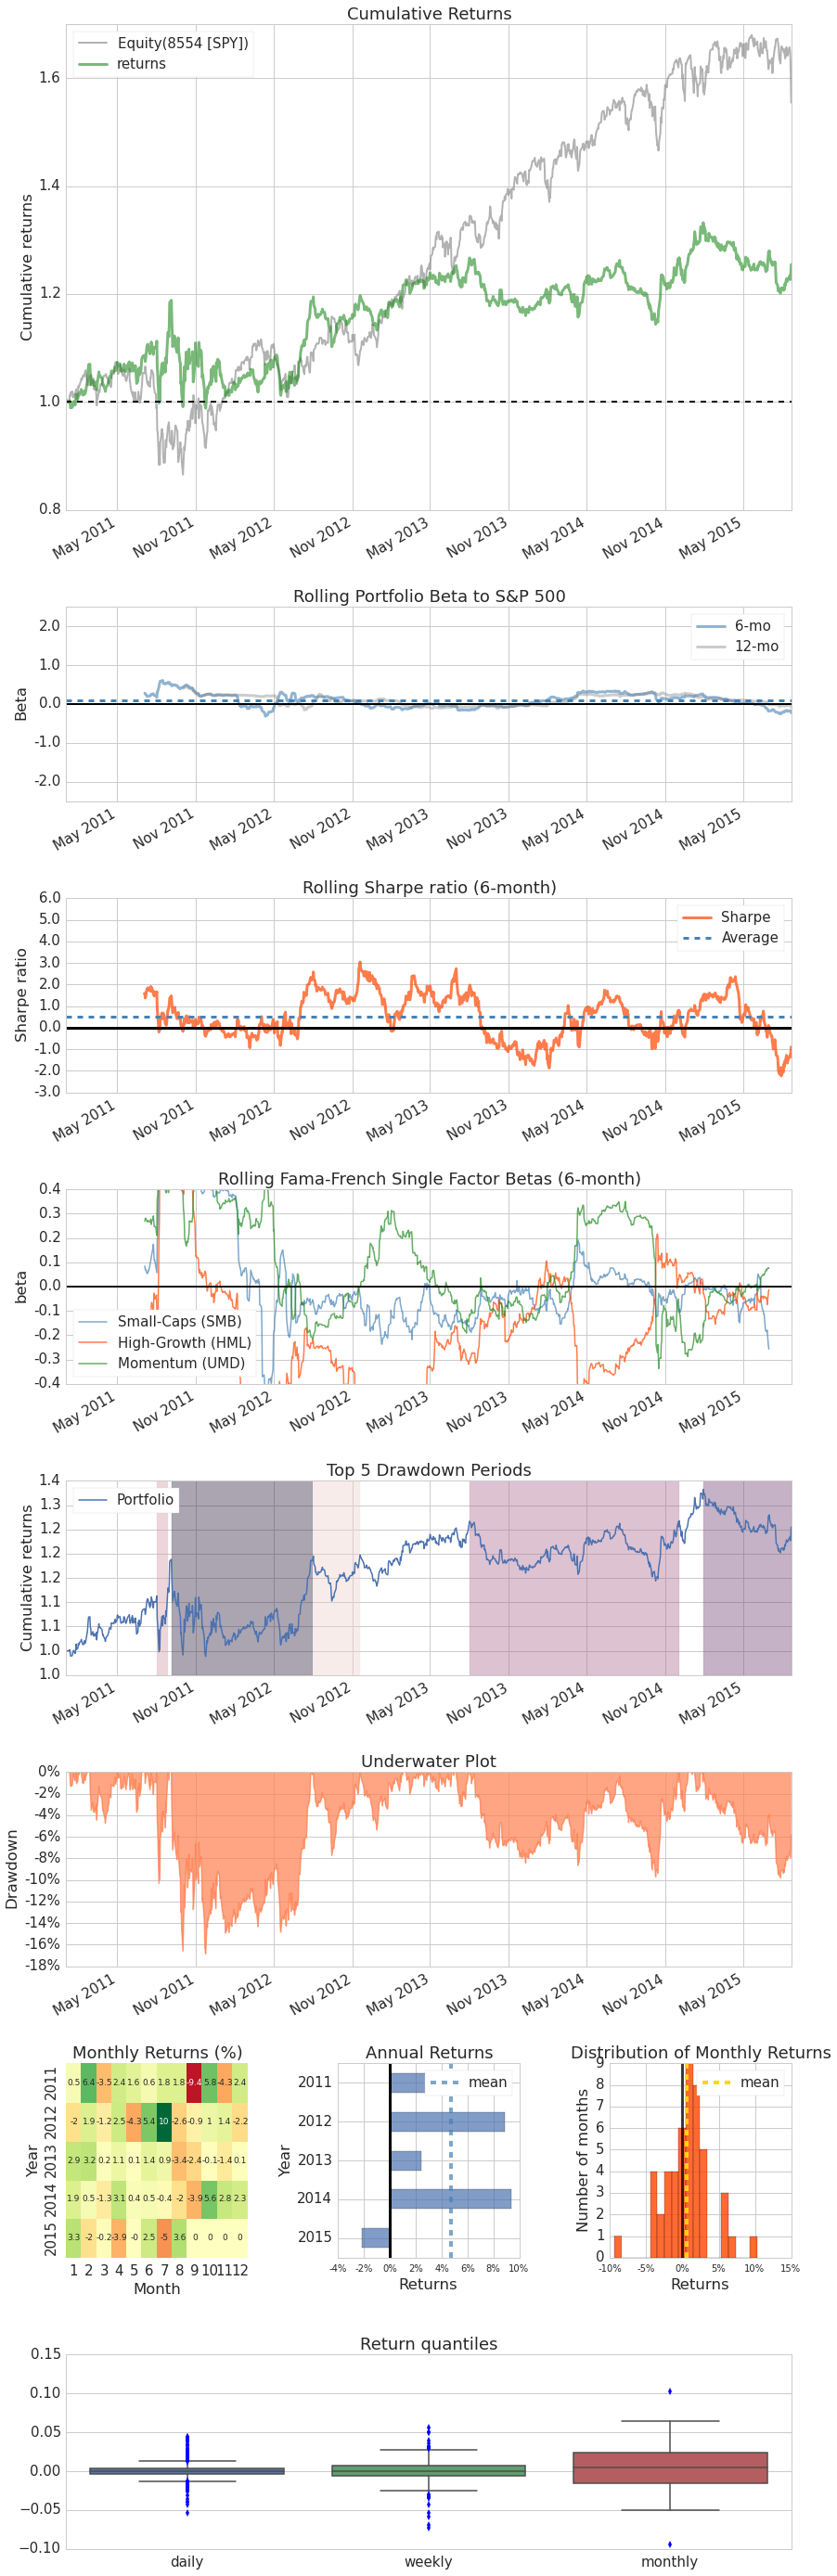

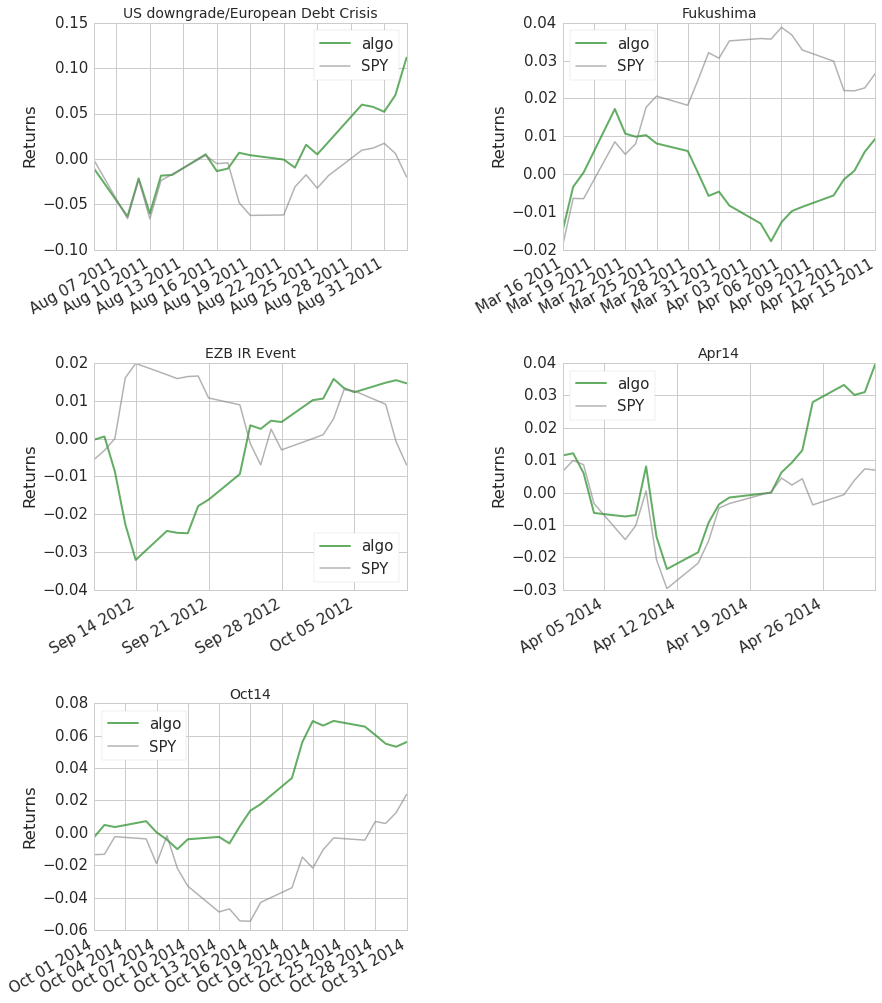

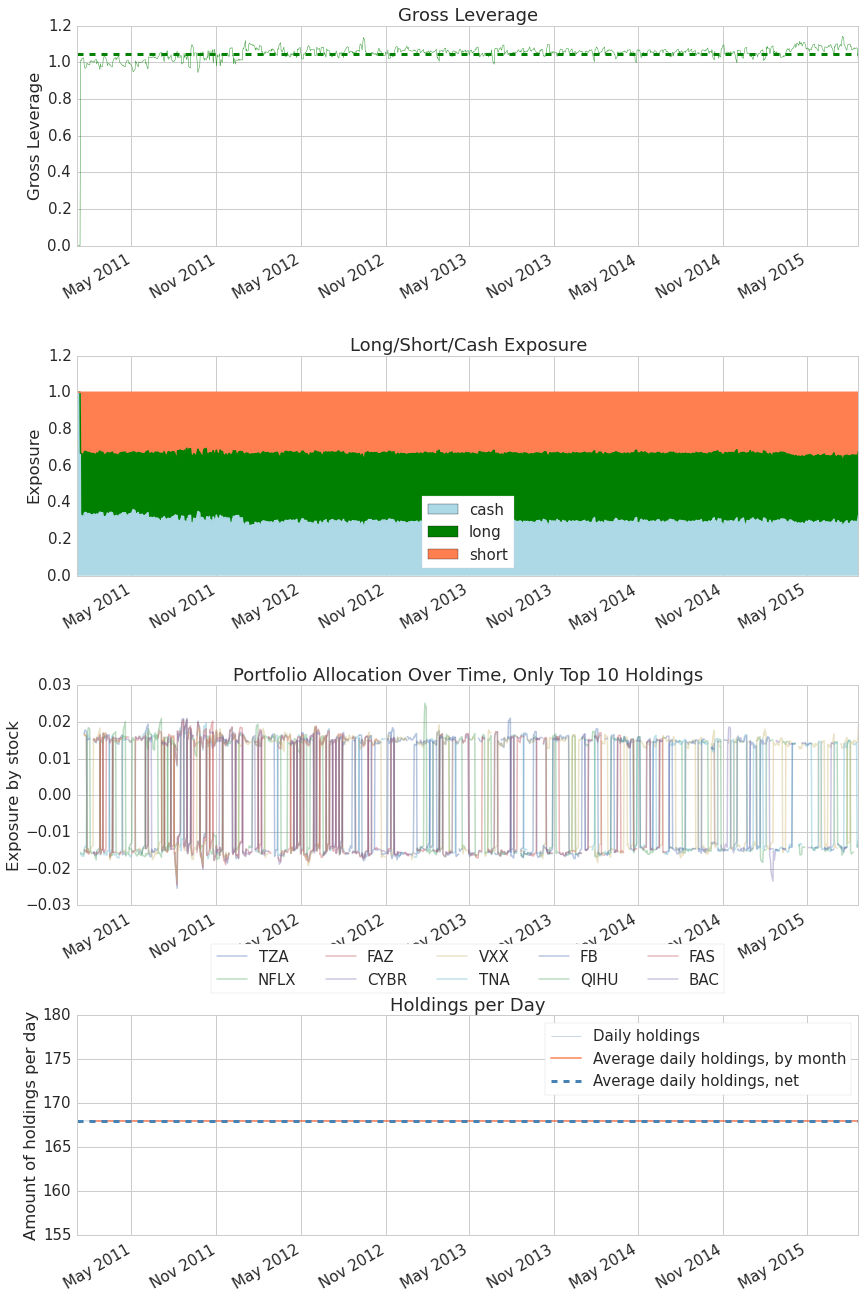

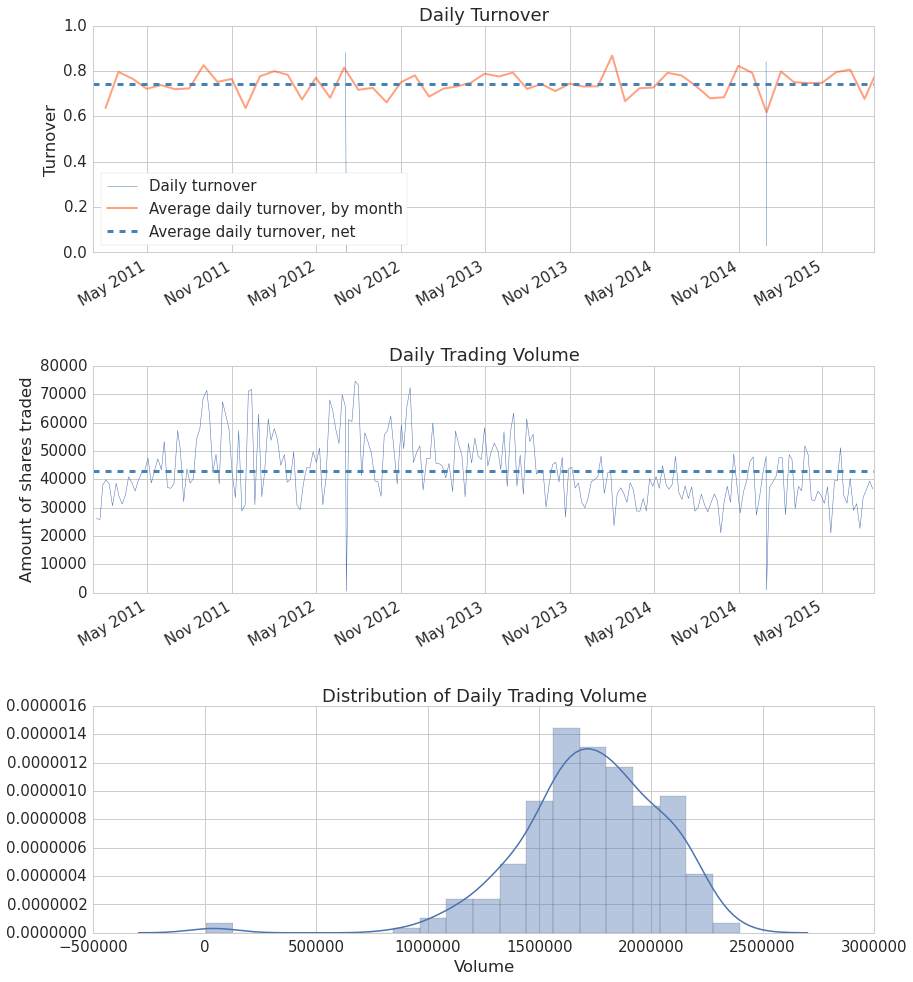

In [7]:
# Get backtest object
bt = get_backtest('55db2def35e3b00d9986aa99')

# Create all tear sheets
bt.create_full_tear_sheet()

## Interpreting the output

There are many metrics being reported in all the tear sheets above. At the top, there are tables that tell you about summary performance statistics like the Sharpe ratio, Sortino ratio, and worst drawdown periods. The following plots are hopefully pretty self-explanatory, but more information can be found on the [pyfolio website](http://quantopian.github.io/pyfolio/).

## More fine-grained access

As the name suggests, `create_full_tear_sheet()` creates all tear sheets available (except for the Bayesian one, see below). You can also create individual tear sheets. For example, lets create one that only uses the returns of your strategy. 

In addition, we will pass in a keyword argument called `live_start_date`. The use-case for this feature is that you might have deployed this algorithm and want to see how the out-of-sample period measures up to your backtest. Although it currently is not possible to access returns from live-traded algorithms in research, you could still note the date when you deployed it and run a new backtest over the full time period. This date can be passed with `live_start_date`. Lets pretend that we developed and deployed this algorithm on `2014-1-1`. As I had access to 10 years of historical data, I could have easily overfit my algorithm to only work well on that time period. In fact, it is very difficult *not* to overfit, so comparing in-sample and out-of-sample (OOS) data is a good way to look at that.

This time, we will create just the returns tear sheet on the same backtest object from above:

Entire data start date: 2011-01-04 00:00:00+00:00
Entire data end date: 2015-08-21 00:00:00+00:00


Out-of-Sample Months: 19
Backtest Months: 35
                   Backtest  Out_of_Sample  All_History
annual_return          0.06           0.05         0.06
annual_volatility      0.15           0.09         0.13
sharpe_ratio           0.43           0.51         0.44
calmar_ratio           0.38           0.46         0.34
stability              0.72           0.30         0.77
max_drawdown          -0.17          -0.10        -0.17
omega_ratio            1.09           1.09         1.09
sortino_ratio          0.59           0.84         0.61
skewness               0.17           0.40         0.21
kurtosis               6.11           2.40         7.31
alpha                  0.04           0.04         0.04
beta                   0.15           0.08         0.13

Worst Drawdown Periods
   net drawdown in %                  peak date                valley date  \
0              16.84  201

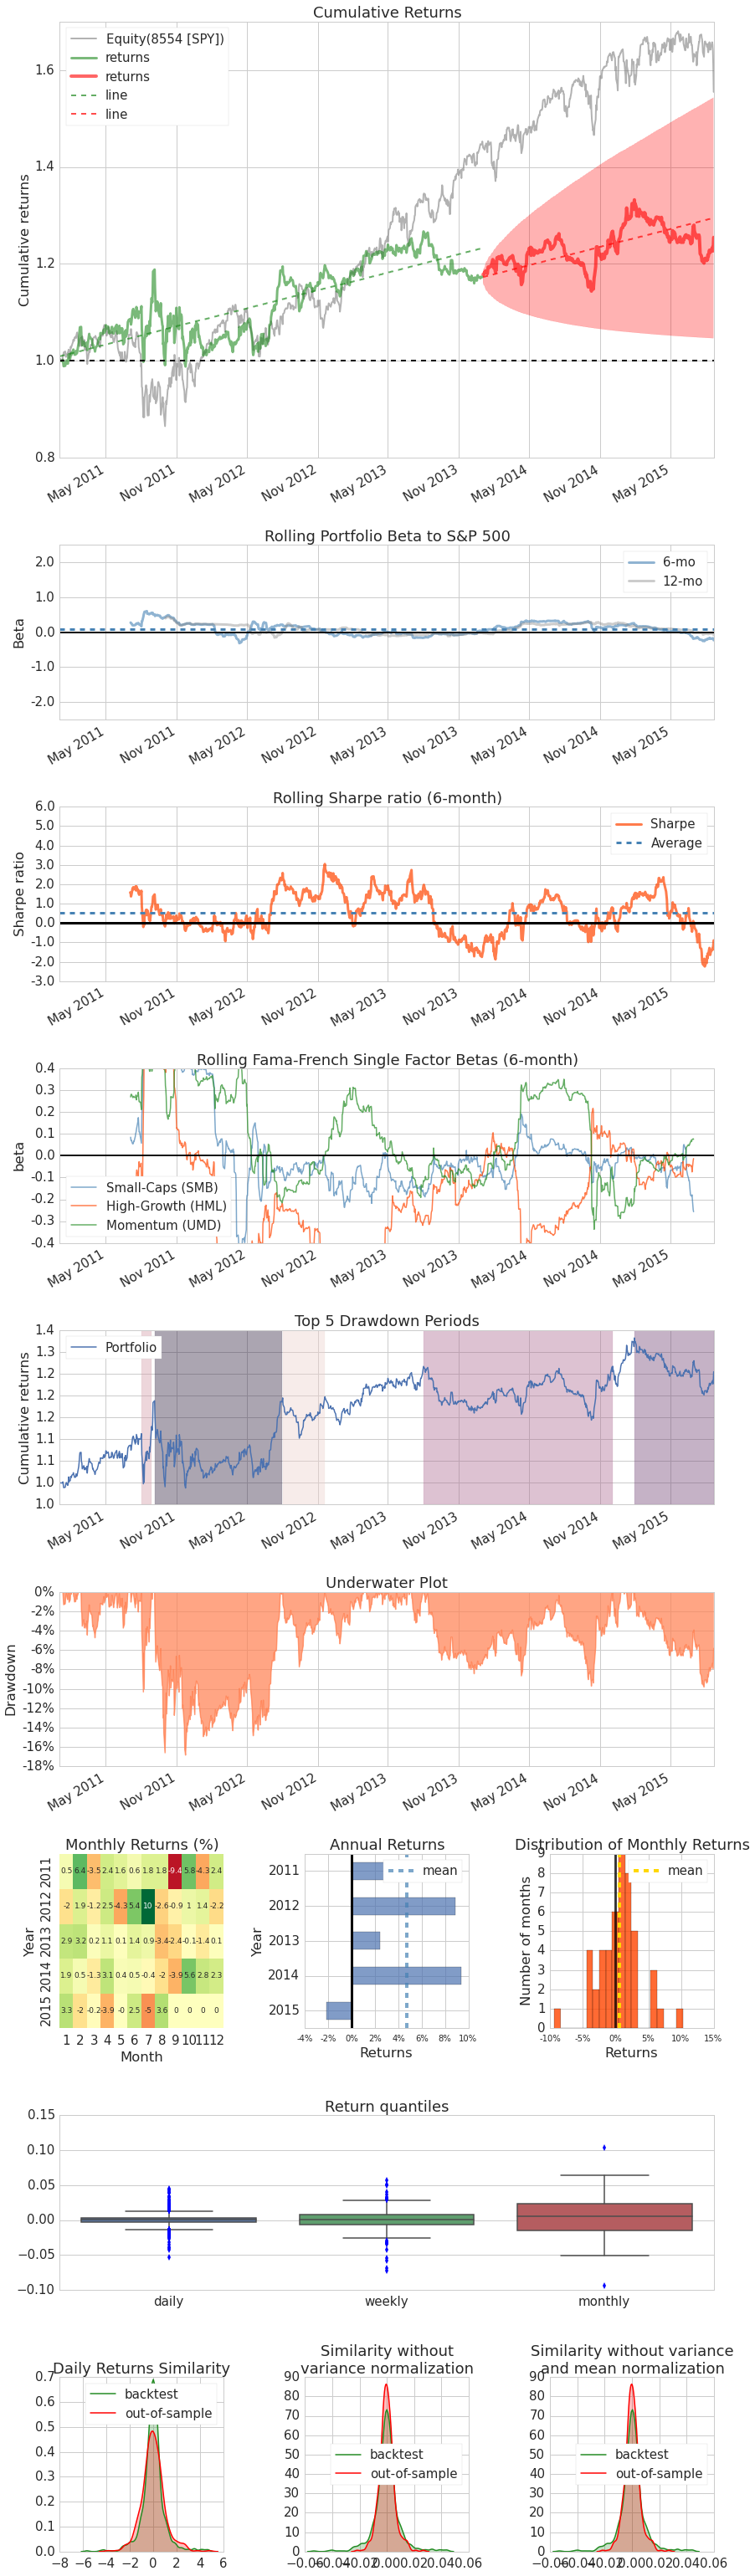

In [3]:
bt.create_returns_tear_sheet(live_start_date='2014-1-1')

There are a few differences in the returns tear sheet that was created. Note for example that the performance table at the top now has 3 columns: `Backtest`, `Out_of_Sample`, and `All_History`. 

The cumulative returns plot also differentiates between in-sample and OOS time periods. In addition, there is a cone that gives you an indiciation of how your algorithm is performing OOS compared to in it's backtest.

At the bottom we also see 3 distribution plots comparing the in-sample and OOS returns distributions. The first one standardizes both distributions to have the same mean and standard deviation of 1. The other two plots relax this standardization.

## Bayesian analysis

There are also a few more advanced (and still experimental) analysis methods in pyfolio based on Bayesian statistics. 

The main benefit of these methods is **uncertainty quantification**. All the values you saw above, like the Sharpe ratio, are just single numbers. These estimates are noisy because they have been computed over a limited number of data points. So how much can you trust these numbers? You don't know because there is no sense of uncertainty. That is where Bayesian statistics helps as instead of single values, we are dealing with probability distributions that assign degrees of belief to all possible parameter values.

Lets create the Bayesian tear sheet. Under the hood this is running MCMC sampling in [`PyMC3`](http://pymc-devs.github.io/pymc3/) to estimate the posteriors which can take quite a while (that's the reason why we don't generate this by default in `create_full_tear_sheet()`).

 [-----------------100%-----------------] 2000 of 2000 complete in 2.9 sec

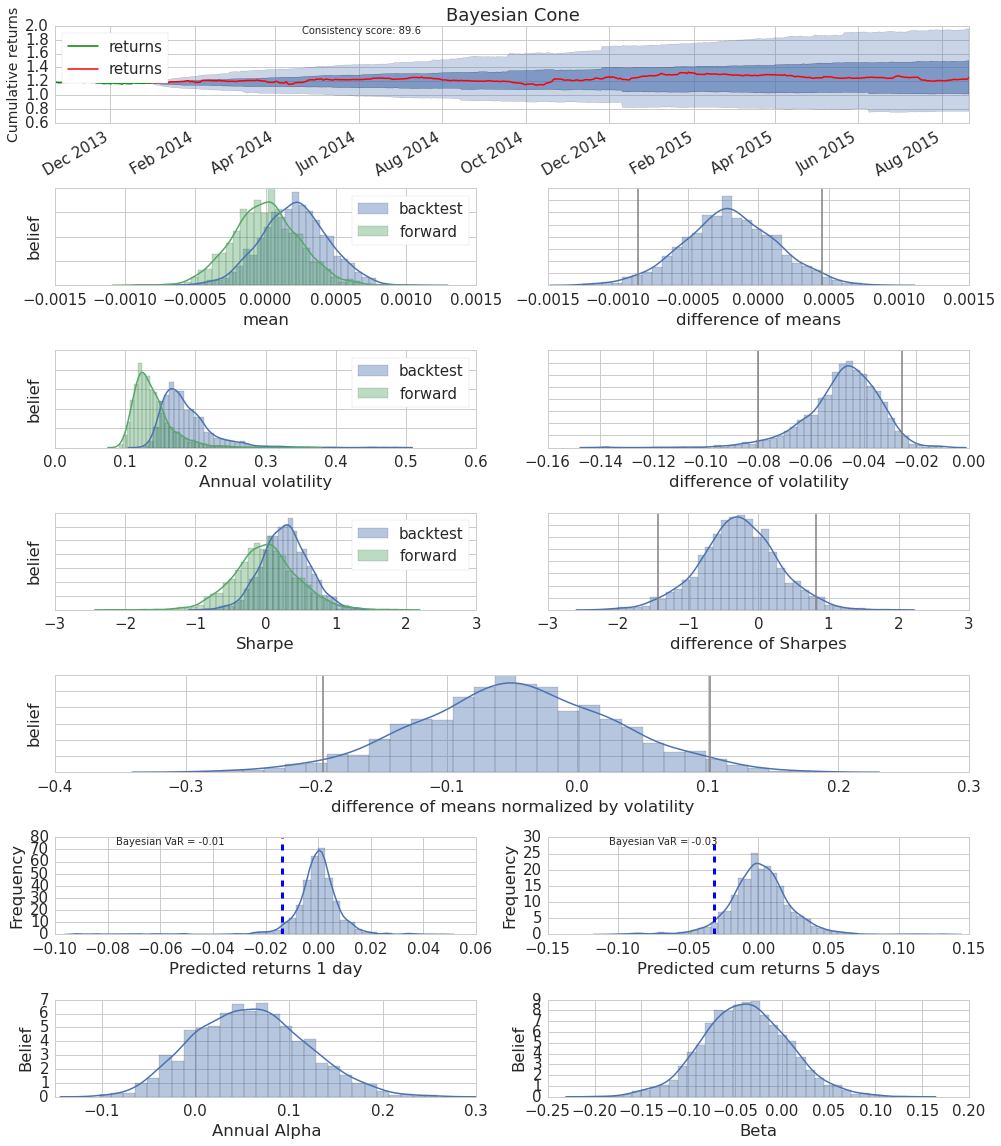

In [8]:
bt.create_bayesian_tear_sheet(live_start_date='2014-1-1')

Lets go through these row by row:

* The first one is the Bayesian cone plot that is the result of a summer internship project of Sepideh Sadeghi here at Quantopian. It's similar to the cone plot you already saw at in the tear sheet above but has two critical additions: (i) it takes uncertainty into account (i.e. a short backtest length will result in a wider cone), and (ii) it does not assume normality of returns but instead uses a [Student-T distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with heavier tails.
* The next row is comparing mean returns of the in-sample (backest) and OOS (forward) period. As you can see, mean returns are not a single number but a (posterior) distribution that gives us an indication of how certain we can be in our estimates. As you can see, the green distribution on the left side is much wider representing our increased uncertainty due to having less OOS data. We can then calculate the difference between these two distributions as shown on the right side. The grey lines denote the 2.5% and 97.5% percentiles. Intuitively, if the right grey line is lower than 0 you can say that with probability > 97.5% the OOS mean returns are below what is suggested by the backtest. The model used here is called [BEST](http://www.indiana.edu/~kruschke/BEST/BEST.pdf) and was developed by John Kruschke.
* The next couple of rows follow the same pattern but are an estimate of annual volatility, Sharpe ratio and their respective differences.
* The 5th row shows the effect size or the difference of means normalized by the standard deviation and gives you a general sense how far apart the two distributions are. Intuitively, even if the means are significantly different, it may not be very meaningful if the standard deviation is huge amounting to a tiny difference of the two returns distributions.
* The 6th row shows predicted returns (based on the backtest) for tomorrow, and 5 days from now. The blue line indicates the probability of losing more than 5% of your portfolio value and can be interpeted as a Bayesian VaR estimate.
* Lastly, a Bayesian estimate of annual alpha and beta. In addition to uncertainty estimates, this model, like all above ones, assumes returns to be T-distributed which leads to more robust estimates than a standard linear regression would.

For more information on Bayesian statistics, check out these resources:
* My personal blog: http://twiecki.github.io/
* A talk I gave in Singapore on Probabilistic Programming in Quantitative Finance: http://blog.quantopian.com/probabilistic-programming-for-non-statisticians/
* The IPython NB book [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).

## Using pyfolio directly

Above, we saw how we can easily create a variety of tear sheets. These are all created using a thin wrapper on top of the pyfolio OSS library. You might also want more fine-grained access over the functionality provided by this library. For this, you can `import pyfolio` and use it directly.

In [5]:
import pyfolio as pf

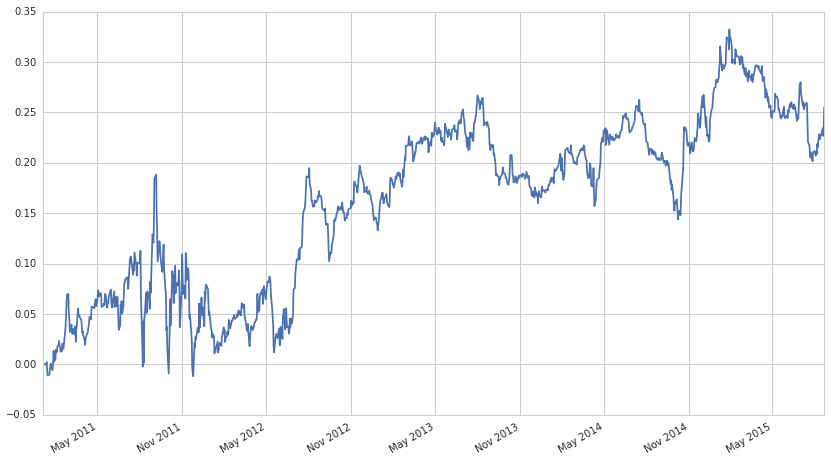

In [6]:
returns = bt.daily_performance.returns
pf.timeseries.cum_returns(returns).plot();

For more information on the usage of the library, check out the pyfolio [website](http://quantopian.github.io/pyfolio/) or our [GitHub repo](https://github.com/quantopian/pyfolio).

## Contributing

pyfolio is still a very new project — there will be bugs and there are many rough edges. Your help is greatly appreciated.

If you find bugs or have other questions, please report them to our [issue tracker](https://github.com/quantopian/pyfolio/issues). We also appreciate any contributions. For some ideas on where to start, see the ['help wanted' tag](https://github.com/quantopian/pyfolio/labels/help%20wanted).